## Problem 80
### Clean, Preprocess data

In [26]:
import re
from collections import Counter
import string
import os
import time

import pandas as pd
from sklearn.model_selection import train_test_split
import torch, torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import gensim

valid_publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com','Daily Mail']
columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
# files = ['train', 'valid', 'test']
label_map = {'b':0, 'e': 1, 'm':2, 't':3}
categs = ['busi.', 'enter.', 'health', 'science']
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
device = torch.device('cuda')

In [27]:
df = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv', sep='\t', quoting=3, names=columns)
df = df[df.PUBLISHER.isin(valid_publishers)]

In [28]:
def sent_tokenizer(title):
    title = re.sub(
        r'[!@#$%^&*()_+\-=\[\]\\;\':\",./<>?]+',
        ' ',
        title)
    title = title.split()
    if '' in title:
        print(title)
    title = [word.lower().strip() for word in title if len(word)>=1]
    return title

df['LABELS'] = df['CATEGORY'].apply(lambda x: label_map[x])
X = df['TITLE'].copy().tolist()
y = df['LABELS'].copy().to_numpy()
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=4, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size=0.5, random_state=4, stratify=y_rem)
# all_data = {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, \
#             'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}
tokens = []
for title in df['TITLE']:
    title = sent_tokenizer(title)
    tokens.extend(title)

token_count = Counter(tokens)
token_count = sorted(token_count.items(), key=lambda x: x[1], reverse=True)
token_index = {token:idx for idx, (token, count) in enumerate(token_count, 1) if count > 1}

In [29]:
def title_vectorizer(title, token_index=token_index, N=len(token_index)):
    title_tokens = sent_tokenizer(title)
    title_tokens = [token_index.get(token, 0) for token in title_tokens]
    return title_tokens

In [30]:
text = df.iloc[1, df.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {title_vectorizer(text)}')

テキスト: ECB FOCUS-Stronger euro drowns out ECB's message to keep rates low for  ...
ID列: [38, 635, 1686, 33, 0, 49, 38, 2, 1571, 1, 788, 220, 70, 6]


## Problem 81
### Implementing a RNN Classifier

In [31]:
class CreateDataset(Dataset):
    def __init__(self, data, label, to_vector=None, transform=None):
        self.transform = transform
        self.data = data
        self.label = label
        self.datanum = label.shape[0]
        self.to_vector = to_vector

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        out_data = self.to_vector(out_data)
        
        if self.transform:
            out_data = self.transform(out_data)
            out_label = self.transform(out_label)
            
        return [out_data, out_label]

In [32]:
train_set = CreateDataset(X_train, y_train, to_vector=title_vectorizer, transform=torch.as_tensor)
valid_set = CreateDataset(X_valid, y_valid, to_vector=title_vectorizer, transform=torch.as_tensor)
test_set = CreateDataset(X_test, y_test, to_vector=title_vectorizer, transform=torch.as_tensor)
all_sets = {'train': train_set, 'valid': valid_set, 'test': test_set}

In [33]:
class SimplestRNNModel(nn.Module):
    def __init__(self, vocab_size, emb_size, output_size, hidden_size, device=None):
        super(SimplestRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.embedding = nn.Embedding(vocab_size+1, emb_size, padding_idx=vocab_size)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        
        #1 * batch_size * hidden
        hidden = self.init_hidden()
        
        #batch_size * seq_leng * emb_size
        x = self.embedding(x) 
        
        # batch_size * seq_leng * (1 * hidden)
        output, hidden = self.rnn(x, hidden) 
        
        output = self.fc(output[:, -1 ,: ])
        
        return output
         
    def init_hidden(self):
        hidden =  torch.zeros(1, self.batch_size, self.hidden_size).to(self.device)
        return hidden

In [143]:
VOCAB_SIZE = len(token_index)
EMBED_SIZE = 300
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = SimplestRNNModel(VOCAB_SIZE, EMBED_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
for idx in range(10):
    features, labels = train_set[idx]
#     print(features)
    preds = model(features.unsqueeze(0))
    out = F.softmax(preds, dim=-1)
    print(out)

tensor([[0.2926, 0.1782, 0.1543, 0.3749]], grad_fn=<SoftmaxBackward>)
tensor([[0.4267, 0.1318, 0.1747, 0.2669]], grad_fn=<SoftmaxBackward>)
tensor([[0.3832, 0.1982, 0.1969, 0.2217]], grad_fn=<SoftmaxBackward>)
tensor([[0.1068, 0.2367, 0.2443, 0.4122]], grad_fn=<SoftmaxBackward>)
tensor([[0.1943, 0.1553, 0.2889, 0.3614]], grad_fn=<SoftmaxBackward>)
tensor([[0.3411, 0.2640, 0.1756, 0.2194]], grad_fn=<SoftmaxBackward>)
tensor([[0.2009, 0.2799, 0.2748, 0.2443]], grad_fn=<SoftmaxBackward>)
tensor([[0.3451, 0.1707, 0.3803, 0.1039]], grad_fn=<SoftmaxBackward>)
tensor([[0.3151, 0.2601, 0.1692, 0.2556]], grad_fn=<SoftmaxBackward>)
tensor([[0.4021, 0.1701, 0.2691, 0.1586]], grad_fn=<SoftmaxBackward>)


## Problem 82
### Training an RNN classifier using SGD

In [34]:
def get_accuracy_batchless(model, split):
    data_loader = DataLoader(all_sets[split], batch_size=1)
    correct = 0
    for batch in data_loader:
        feature, label = batch
        correct += get_correct_response(model, feature, label)
    return correct/len(all_sets[split])

In [35]:
@torch.no_grad()
def get_correct_response(model, features, labels):
    preds = model(features)
    return F.softmax(preds, dim=-1).argmax(dim=-1).eq(labels).sum().item()

In [36]:
@torch.no_grad()
def get_valid_loss_batchless(model, criterion=None):
    eval_loader = DataLoader(all_sets['valid'], batch_size=1)
#     batch_nums = 0
    all_loss = 0
    for idx, batch in enumerate(eval_loader, 1):
        feature, label = batch
        out = model(feature)
        loss = F.cross_entropy(out, label)
        all_loss += loss
#         batch_nums = idx
    return all_loss/idx

In [37]:
def plot_graphs(losses, accs):
    train_losses, valid_losses = zip(*losses)
    plt.figure(figsize=(10, 4))
    plt.title('Avg batch loss per epoch')
    plt.plot(range(len(train_losses)), train_losses, label='training loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()
    
    train_accs, valid_accs = zip(*accs)
    plt.figure(figsize=(10, 4))
    plt.title('Accuracy after each epoch')
    plt.plot(range(len(train_accs)), train_accs, label='training acc')
    plt.plot(range(len(valid_accs)), valid_accs, label='valid acc')
    plt.legend()

In [38]:
def train_simple_rnn(model, num_epoch, b_size, l_rate, pad_seq=None, verbose=True):
    optimizer  = optim.SGD(model.parameters(), lr=l_rate)
    train_loader = DataLoader(train_set, batch_size=b_size)
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        batch_nums = 0
        for idx, batch in enumerate(train_loader, 1):
            feature, label = batch
            out = model(feature)
            loss = F.cross_entropy(out, label)
            epoch_loss += loss
            batch_nums = idx

            #training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = epoch_loss/batch_nums
        valid_loss = get_valid_loss_batchless(model, criterion=criterion)
        train_acc = get_accuracy_batchless(model, 'train')
        valid_acc = get_accuracy_batchless(model, 'valid')
        losses.append([train_loss, train_loss])
        accuracies.append([train_acc, valid_acc])
        if verbose:
            print(f'epoch: {epoch+1}, training loss: {train_loss.item()}, valid loss: {valid_loss.item()}')
            print(f'training accuracy: {train_acc}, valid accuracy: {valid_acc}')
    
    return losses, accuracies

epoch: 1, training loss: 1.1932892799377441, valid loss: 1.1316261291503906
training accuracy: 0.525926619243729, valid accuracy: 0.48502994011976047
epoch: 2, training loss: 1.0735007524490356, valid loss: 1.0711191892623901
training accuracy: 0.592661924372894, valid accuracy: 0.5494011976047904
epoch: 3, training loss: 0.9877458810806274, valid loss: 0.9801419377326965
training accuracy: 0.6590228378884313, valid accuracy: 0.6182634730538922
epoch: 4, training loss: 0.8327471017837524, valid loss: 0.7909700274467468
training accuracy: 0.7487832272557094, valid accuracy: 0.7200598802395209
epoch: 5, training loss: 0.6743304133415222, valid loss: 0.6996287107467651
training accuracy: 0.7931486334706103, valid accuracy: 0.7440119760479041
epoch: 6, training loss: 0.566768229007721, valid loss: 0.6475796699523926
training accuracy: 0.8185136652938975, valid accuracy: 0.7589820359281437
epoch: 7, training loss: 0.48700016736984253, valid loss: 0.620070219039917
training accuracy: 0.84387

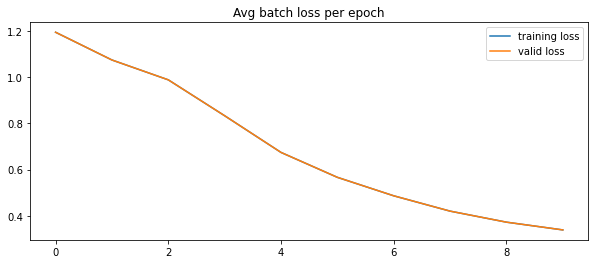

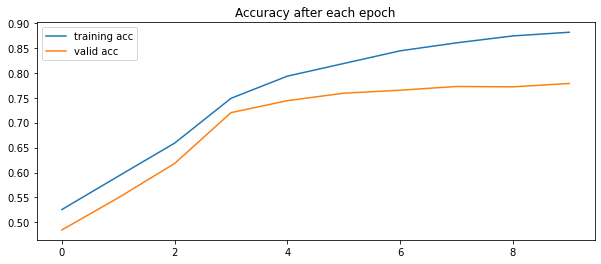

In [156]:
VOCAB_SIZE = len(token_index)
EMBED_SIZE = 300
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_EPOCH = 10
BATCH_SIZE = 1
L_RATE = 0.001

model = SimplestRNNModel(VOCAB_SIZE, EMBED_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
losses, accs = train_simple_rnn(model, NUM_EPOCH, BATCH_SIZE, L_RATE)
plot_graphs(losses, accs)

## Problem 83
### Minibatch and GPU_USE

In [39]:
class PadSequence:
    def __call__(self, batch, pad_idx=len(token_index)):
        # Let's assume that each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=pad_idx)
        # Also need to store the length of each sequence
        # This is later needed in order to unpad the sequences
        lengths = torch.LongTensor([len(x) for x in sequences])
        # Don't forget to grab the labels of the *sorted* batch
        labels = torch.LongTensor(list(map(lambda x: x[1], sorted_batch)))
        return sequences_padded, lengths, labels

In [40]:
def get_accuracy(model, split, device=None, pad_seq=None, datasets=all_sets):
    data_loader = DataLoader(datasets[split], batch_size=len(datasets[split]), collate_fn=pad_seq)
    correct = 0
    for batch in data_loader:
        features, lengths, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        correct += get_correct_response(model, features, labels)
    return correct/len(datasets[split])

In [41]:
@torch.no_grad()
def get_valid_loss(model, bsize, device=None, pad_seq=None, datasets=all_sets):
    eval_loader = DataLoader(datasets['valid'], batch_size=bsize, collate_fn=pad_seq)
    batch_nums = 0
    all_loss = 0
    for idx, batch in enumerate(eval_loader, 1):
        features, lengths, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        out = model(features)
        loss = F.cross_entropy(out, labels)
        all_loss += loss
        batch_nums = idx
    return all_loss/batch_nums

In [42]:
def train_batch(model, num_epoch, b_size, l_rate, pad_seq=None, device=None, verbose=True):
    optimizer  = optim.SGD(model.parameters(), lr=l_rate)
    train_loader = DataLoader(train_set, batch_size=b_size, collate_fn=pad_seq)
    model = model.to(device)
#     print(next(model.parameters()).device)
    losses = []
    accuracies = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        batch_nums = 0
        for idx, batch in enumerate(train_loader, 1):
#             print(idx)
            features, lengths, labels = batch
            features = features.to(device)
            labels = labels.to(device)
#             print(features.get_device() ,labels.get_device(), next(model.parameters()).device)
            out = model(features)
            loss = F.cross_entropy(out, labels)
            epoch_loss += loss
            batch_nums = idx
            
            #training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss = epoch_loss/batch_nums
        valid_loss = get_valid_loss(model, b_size, device=device, pad_seq=pad_seq)
        train_acc = get_accuracy(model, 'train', device=device, pad_seq=pad_seq)
        valid_acc = get_accuracy(model, 'valid', device=device, pad_seq=pad_seq)
        losses.append([train_loss, valid_loss])
        accuracies.append([train_acc, valid_acc])
        if verbose:
            print(f'epoch: {epoch+1}, training loss: {train_loss.item():.3f}, valid loss: {valid_loss.item():.3f}')
            print(f'training accuracy: {train_acc:.3f}, valid accuracy: {valid_acc:.3f}')
    return losses, accuracies
    

epoch: 1, training loss: 1.171, valid loss: 1.146
training accuracy: 0.448, valid accuracy: 0.473
epoch: 2, training loss: 1.097, valid loss: 1.050
training accuracy: 0.621, valid accuracy: 0.592
epoch: 3, training loss: 0.995, valid loss: 0.981
training accuracy: 0.683, valid accuracy: 0.663
epoch: 4, training loss: 0.976, valid loss: 0.973
training accuracy: 0.684, valid accuracy: 0.660
epoch: 5, training loss: 0.958, valid loss: 0.980
training accuracy: 0.674, valid accuracy: 0.660
epoch: 6, training loss: 0.906, valid loss: 0.906
training accuracy: 0.708, valid accuracy: 0.686
epoch: 7, training loss: 0.866, valid loss: 0.907
training accuracy: 0.725, valid accuracy: 0.683
epoch: 8, training loss: 0.815, valid loss: 0.825
training accuracy: 0.715, valid accuracy: 0.685
epoch: 9, training loss: 1.009, valid loss: 1.094
training accuracy: 0.598, valid accuracy: 0.570
epoch: 10, training loss: 0.965, valid loss: 0.935
training accuracy: 0.691, valid accuracy: 0.667


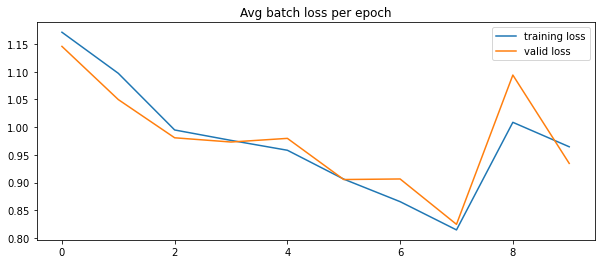

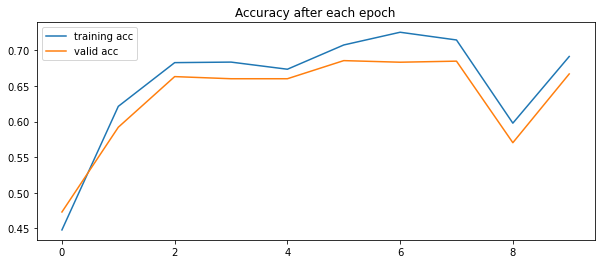

In [155]:
VOCAB_SIZE = len(token_index)
EMBED_SIZE = 300
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_EPOCH = 10
BATCH_SIZE = 32
L_RATE = 0.005

model = SimplestRNNModel(VOCAB_SIZE, EMBED_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, device=device)
losses, accs = train_batch(model, NUM_EPOCH, BATCH_SIZE, L_RATE, pad_seq=PadSequence(), device=device)
plot_graphs(losses, accs)

## Problem-84
### Initialize embedding layer with w2v

In [43]:
#pretrained word2vec model trained by google on wikipedia corpus
w2vmodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [44]:
emb_dim = 300
not_in_dict = 0
initial_weights = [np.zeros(emb_dim)]
# print(len(token_index.keys()))
for idx, item in enumerate(token_index.items()):
    key, val = item
    if key in w2vmodel:
        initial_weights.append(w2vmodel[key])
    else:
        initial_weights.append(np.zeros(emb_dim))
        not_in_dict+=1
initial_weights.append(np.zeros(emb_dim))
initial_embeddings = torch.stack([torch.tensor(i, dtype=torch.float32) for i in initial_weights])
print(not_in_dict)
print(initial_embeddings.shape)

1035
torch.Size([8614, 300])


In [45]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, emb_size, output_size, hidden_size, num_layers=1, bidirec=False, embeddings=None, device=None):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.num_layers = num_layers
        self.D = 2 if bidirec else 1
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size+1, emb_size, padding_idx=vocab_size)
        self.rec_layer = nn.RNN(emb_size, hidden_size, num_layers=self.num_layers, nonlinearity='tanh', batch_first=True, bidirectional=bidirec)
        self.fc = nn.Linear(hidden_size*self.D, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden()
        x = self.embedding(x) #batch_size * seq_leng * emb_size
        output, hidden = self.rec_layer(x, hidden) # batch_size * seq_leng * (1 * hidden), 1 * batch_size * hidden
        output = self.fc(output[:, -1 ,: ])
        return output #batch_size * 1 * output_classes
        
    def init_hidden(self):  
        hidden =  torch.zeros(self.num_layers*self.D, self.batch_size, self.hidden_size).to(self.device)
        return hidden

epoch: 1, training loss: 0.982, valid loss: 1.014
training accuracy: 0.655, valid accuracy: 0.618
epoch: 2, training loss: 0.929, valid loss: 0.960
training accuracy: 0.688, valid accuracy: 0.657
epoch: 3, training loss: 0.864, valid loss: 0.960
training accuracy: 0.691, valid accuracy: 0.668
epoch: 4, training loss: 0.794, valid loss: 0.825
training accuracy: 0.751, valid accuracy: 0.721
epoch: 5, training loss: 0.727, valid loss: 0.773
training accuracy: 0.762, valid accuracy: 0.729
epoch: 6, training loss: 0.676, valid loss: 0.787
training accuracy: 0.758, valid accuracy: 0.718
epoch: 7, training loss: 0.623, valid loss: 0.722
training accuracy: 0.794, valid accuracy: 0.748
epoch: 8, training loss: 0.572, valid loss: 0.708
training accuracy: 0.805, valid accuracy: 0.749
epoch: 9, training loss: 0.537, valid loss: 0.703
training accuracy: 0.807, valid accuracy: 0.759
epoch: 10, training loss: 0.499, valid loss: 0.746
training accuracy: 0.801, valid accuracy: 0.743


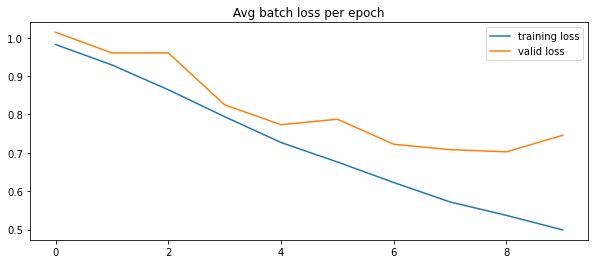

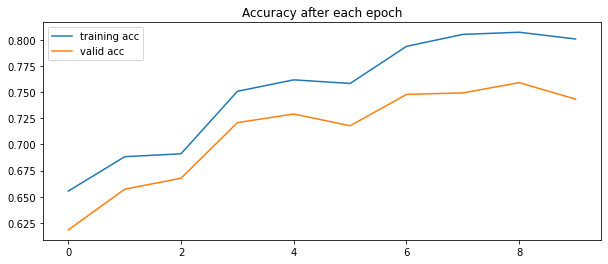

In [19]:
VOCAB_SIZE = len(token_index)
EMBED_SIZE = 300
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_EPOCH = 10
BATCH_SIZE = 32
L_RATE = 0.01

model = RNNModel(VOCAB_SIZE, EMBED_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, num_layers=2, bidirec=True, \
                 embeddings=None, device=device)
losses, accs = train_batch(model, NUM_EPOCH, BATCH_SIZE, L_RATE, pad_seq=PadSequence(), device=device)
plot_graphs(losses, accs)

## Problem-86
### Implementing a CNN model

#### might be good to use activation after pooling and adding dropout to this and subsequent models

In [46]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, emb_size, output_size, hidden_size, filter_size, stride, padding, embeddings=None):
        super(CNNModel, self).__init__()
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(embeddings, padding_idx=vocab_size)
        else:
            self.embedding = nn.Embedding(vocab_size+1, emb_size, padding_idx=vocab_size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=(filter_size, emb_size), stride=stride, padding=(padding, 0))
        self.fc1 = nn.Linear(in_features=hidden_size, out_features=output_size, )
        
        
    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))
        x = self.conv1(x)
        x = F.max_pool1d(x.squeeze(3), x.shape[2])
        x = self.fc1(x.squeeze(2))
        return x

In [22]:
VOCAB_SIZE = len(token_index)
EMB_SIZE = 300
HIDDEN_SIZE = 50
OUTPUT_SIZE = 4 
STRIDE = 1
PADDING = 1
FILTER_SIZE = 3



model = CNNModel(VOCAB_SIZE, EMB_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, FILTER_SIZE, STRIDE, PADDING)
for idx in range(10):
    feature, label = train_set[idx]
    pred = F.softmax(model(feature.unsqueeze(0)), dim=-1)
    print(pred)

tensor([[0.0867, 0.2957, 0.4979, 0.1197]], grad_fn=<SoftmaxBackward>)
tensor([[0.0842, 0.1762, 0.5507, 0.1889]], grad_fn=<SoftmaxBackward>)
tensor([[0.1020, 0.1819, 0.5988, 0.1172]], grad_fn=<SoftmaxBackward>)
tensor([[0.1006, 0.2290, 0.4581, 0.2123]], grad_fn=<SoftmaxBackward>)
tensor([[0.1295, 0.2941, 0.3939, 0.1825]], grad_fn=<SoftmaxBackward>)
tensor([[0.1181, 0.2571, 0.3572, 0.2675]], grad_fn=<SoftmaxBackward>)
tensor([[0.1074, 0.2537, 0.5182, 0.1207]], grad_fn=<SoftmaxBackward>)
tensor([[0.1033, 0.1581, 0.5829, 0.1557]], grad_fn=<SoftmaxBackward>)
tensor([[0.1306, 0.2126, 0.4763, 0.1805]], grad_fn=<SoftmaxBackward>)
tensor([[0.1088, 0.2347, 0.4549, 0.2016]], grad_fn=<SoftmaxBackward>)


/home/is/vipul-mi/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Problem 87
### Training a CNN Classifier with SGD

In [76]:
NUM_EPOCH = 10
BATCH_SIZE = 32
L_RATE = 0.005
train_batch(model, NUM_EPOCH, BATCH_SIZE, L_RATE, pad_seq=PadSequence(), device=device)

epoch: 1, training loss: 1.085, valid loss: 0.969
training accuracy: 0.674, valid accuracy: 0.674
epoch: 2, training loss: 0.899, valid loss: 0.839
training accuracy: 0.721, valid accuracy: 0.704
epoch: 3, training loss: 0.777, valid loss: 0.751
training accuracy: 0.753, valid accuracy: 0.730
epoch: 4, training loss: 0.677, valid loss: 0.683
training accuracy: 0.786, valid accuracy: 0.751
epoch: 5, training loss: 0.592, valid loss: 0.628
training accuracy: 0.818, valid accuracy: 0.769
epoch: 6, training loss: 0.518, valid loss: 0.583
training accuracy: 0.851, valid accuracy: 0.787
epoch: 7, training loss: 0.452, valid loss: 0.546
training accuracy: 0.877, valid accuracy: 0.803
epoch: 8, training loss: 0.396, valid loss: 0.516
training accuracy: 0.899, valid accuracy: 0.812
epoch: 9, training loss: 0.347, valid loss: 0.492
training accuracy: 0.917, valid accuracy: 0.820
epoch: 10, training loss: 0.304, valid loss: 0.473
training accuracy: 0.932, valid accuracy: 0.827


([[tensor(1.0854, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.9686, device='cuda:0')],
  [tensor(0.8994, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.8395, device='cuda:0')],
  [tensor(0.7771, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.7506, device='cuda:0')],
  [tensor(0.6774, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6827, device='cuda:0')],
  [tensor(0.5921, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6284, device='cuda:0')],
  [tensor(0.5177, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5833, device='cuda:0')],
  [tensor(0.4525, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5456, device='cuda:0')],
  [tensor(0.3957, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5156, device='cuda:0')],
  [tensor(0.3466, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.4917, device='cuda:0')],
  [tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.4729, device='cuda:0')]],
 [[0.6738113066267316, 0.6744

## Problem 88
### Hyperparameter tuning of CNN and RNN models
#### Using optuna is another alternative

In [47]:
from collections import OrderedDict, namedtuple
from itertools import product

In [48]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [49]:
cnn_params = OrderedDict(
    L_RATE = [.01, .005, 0.001],
    BATCH_SIZE = [16, 32, 64, 128],
    FILTER_SIZE = [2, 3, 4],
    HIDDEN_SIZE = [50, 100, 200]
)
cnn_results = pd.DataFrame(columns =['Batch Size', 'Learning Rate', 'Hidden Dim', 'Filter Size', 'Max Train Acc.',\
                                 'Max Valid Acc.', 'Final Train Acc.', 'Final Valid Acc.', 'Time_taken'])

In [81]:
VOCAB_SIZE = len(token_index)
EMB_SIZE = 300
OUTPUT_SIZE = 4 
STRIDE = 1
padding_map = {2:0, 3:1, 4:2}
NUM_EPOCH = 10


for idx, run in enumerate(RunBuilder.get_runs(cnn_params)):
    start = time.time()
    model = CNNModel(VOCAB_SIZE, EMB_SIZE, OUTPUT_SIZE, run.HIDDEN_SIZE, run.FILTER_SIZE, STRIDE,\
                     padding_map[run.FILTER_SIZE], embeddings=initial_embeddings)
    losses, accs = train_batch(model, NUM_EPOCH, run.BATCH_SIZE, run.L_RATE, pad_seq=PadSequence(),\
                               device=device, verbose=False)
    train_accs, valid_accs  = zip(*accs)
#     print([idx+1, run.BATCH_SIZE, run.L_RATE, run.HIDDEN_SIZE, run.FILTER_SIZE, max(train_accs),\
#                  max(valid_accs), time.time()-start])
    results.loc[idx] = [run.BATCH_SIZE, run.L_RATE, run.HIDDEN_SIZE, run.FILTER_SIZE, max(train_accs),\
                 max(valid_accs), train_accs[-1], valid_accs[-1], time.time()-start]
    print(idx, 'done', run)

0 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=2, HIDDEN_SIZE=50)
1 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=2, HIDDEN_SIZE=100)
2 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=2, HIDDEN_SIZE=200)
3 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=3, HIDDEN_SIZE=50)
4 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=3, HIDDEN_SIZE=100)
5 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=3, HIDDEN_SIZE=200)
6 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=4, HIDDEN_SIZE=50)
7 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=4, HIDDEN_SIZE=100)
8 done Run(L_RATE=0.01, BATCH_SIZE=16, FILTER_SIZE=4, HIDDEN_SIZE=200)
9 done Run(L_RATE=0.01, BATCH_SIZE=32, FILTER_SIZE=2, HIDDEN_SIZE=50)
10 done Run(L_RATE=0.01, BATCH_SIZE=32, FILTER_SIZE=2, HIDDEN_SIZE=100)
11 done Run(L_RATE=0.01, BATCH_SIZE=32, FILTER_SIZE=2, HIDDEN_SIZE=200)
12 done Run(L_RATE=0.01, BATCH_SIZE=32, FILTER_SIZE=3, HIDDEN_SIZE=50)
13 done Run(L_RATE=0.01, BATCH_SIZE=32, FILTER_SIZE=3, HIDDEN_SIZE=100)
14 done

In [ ]:
cnn_results.to_csv('CNN_hyperparam_tuning.csv')

In [50]:
cnn_params = OrderedDict(
    L_RATE = [.01, .005, 0.001],
    BATCH_SIZE = [16, 32, 64],
    NUM_LAYERS = [2, 3, 4],
    BIDIREC = [True, False],
    HIDDEN_SIZE = [50, 100, 200]
)
rnn_results =  pd.DataFrame(columns =['Batch Size', 'Learning Rate', 'Hidden Dim', 'Num Layers', 'Bidirec',\
                            'Max Train Acc.', 'Max Valid Acc.', 'Final Train Acc.', 'Final Valid Acc.', 'Time_taken'])

In [52]:
VOCAB_SIZE = len(token_index)
EMB_SIZE = 300
OUTPUT_SIZE = 4 
STRIDE = 1
padding_map = {2:0, 3:1, 4:2}
NUM_EPOCH = 10


for idx, run in enumerate(RunBuilder.get_runs(cnn_params)):
    start = time.time()
    model = RNNModel(VOCAB_SIZE, EMB_SIZE, OUTPUT_SIZE, run.HIDDEN_SIZE, num_layers=run.NUM_LAYERS, \
                     bidirec=run.BIDIREC, embeddings=initial_embeddings, device=device)
    losses, accs = train_batch(model, NUM_EPOCH, run.BATCH_SIZE, run.L_RATE, pad_seq=PadSequence(),\
                               device=device, verbose=False)
    train_accs, valid_accs  = zip(*accs)
    rnn_results.loc[idx] = [run.BATCH_SIZE, run.L_RATE, run.HIDDEN_SIZE, run.NUM_LAYERS, run.BIDIREC, max(train_accs),\
                 max(valid_accs), train_accs[-1], valid_accs[-1], time.time()-start]
    print(idx, 'done', run)

0 done Run(L_RATE=0.01, BATCH_SIZE=16, NUM_LAYERS=2, BIDIREC=True, HIDDEN_SIZE=50)
1 done Run(L_RATE=0.01, BATCH_SIZE=16, NUM_LAYERS=2, BIDIREC=True, HIDDEN_SIZE=100)
2 done Run(L_RATE=0.01, BATCH_SIZE=16, NUM_LAYERS=2, BIDIREC=True, HIDDEN_SIZE=200)
3 done Run(L_RATE=0.01, BATCH_SIZE=16, NUM_LAYERS=2, BIDIREC=False, HIDDEN_SIZE=50)
4 done Run(L_RATE=0.01, BATCH_SIZE=16, NUM_LAYERS=2, BIDIREC=False, HIDDEN_SIZE=100)


KeyboardInterrupt: 

In [82]:
rnn_results.to_csv('RNN_hyperparam_tuning.csv')

## Problem 89
### Training a Classifier with inputs obtained from BERT pretrained model

In [53]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [58]:
class BertClassifier(nn.Module):
    def __init__(self, bert_embed_size, output_size):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(bert_embed_size, 200)
        self.fc2 = nn.Linear(200, output_size)
        
    def forward(self, x):
        x = self.bert(x)[1]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [59]:
train_set_bert = CreateDataset(X_train, y_train, to_vector=tokenizer.encode, transform=torch.as_tensor)
valid_set_bert = CreateDataset(X_valid, y_valid, to_vector=tokenizer.encode, transform=torch.as_tensor)
test_set_bert = CreateDataset(X_test, y_test, to_vector=tokenizer.encode, transform=torch.as_tensor)
all_sets_bert = {'train': train_set_bert, 'valid': valid_set_bert, 'test': test_set_bert}

In [60]:
def train_batch(model, num_epoch, b_size, l_rate, pad_seq=None, device=None, verbose=True):
    optimizer  = optim.SGD(model.parameters(), lr=l_rate)
    train_loader = DataLoader(train_set_bert, batch_size=b_size, collate_fn=pad_seq)
    model = model.to(device)
#     print(next(model.parameters()).device)
    losses = []
    accuracies = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        batch_nums = 0
        for idx, batch in enumerate(train_loader, 1):
#             print(idx)
            features, lengths, labels = batch
            features = features.to(device)
            labels = labels.to(device)
#             print(features.get_device() ,labels.get_device(), next(model.parameters()).device)
            out = model(features)
            loss = F.cross_entropy(out, labels)
            epoch_loss += loss
            batch_nums = idx
            
            #training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss = epoch_loss/batch_nums
        valid_loss = get_valid_loss(model, b_size, device=device, pad_seq=pad_seq, datasets=all_sets_bert)
        train_acc = get_accuracy(model, 'train', device=device, pad_seq=pad_seq, datasets=all_sets_bert)
        valid_acc = get_accuracy(model, 'valid', device=device, pad_seq=pad_seq, datasets=all_sets_bert)
        losses.append([train_loss, valid_loss])
        accuracies.append([train_acc, valid_acc])
        if verbose:
            print(f'epoch: {epoch+1}, training loss: {train_loss.item():.3f}, valid loss: {valid_loss.item():.3f}')
            print(f'training accuracy: {train_acc:.3f}, valid accuracy: {valid_acc:.3f}')
    return losses, accuracies

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, training loss: 0.510, valid loss: 0.305
training accuracy: 0.908, valid accuracy: 0.891
epoch: 2, training loss: 0.219, valid loss: 0.198
training accuracy: 0.959, valid accuracy: 0.937
epoch: 3, training loss: 0.136, valid loss: 0.194
training accuracy: 0.972, valid accuracy: 0.938
epoch: 4, training loss: 0.093, valid loss: 0.234
training accuracy: 0.979, valid accuracy: 0.933
epoch: 5, training loss: 0.053, valid loss: 0.268
training accuracy: 0.978, valid accuracy: 0.928
epoch: 6, training loss: 0.046, valid loss: 0.241
training accuracy: 0.988, valid accuracy: 0.938
epoch: 7, training loss: 0.026, valid loss: 0.244
training accuracy: 0.993, valid accuracy: 0.941
epoch: 8, training loss: 0.039, valid loss: 0.263
training accuracy: 0.985, valid accuracy: 0.931
epoch: 9, training loss: 0.065, valid loss: 0.273
training accuracy: 0.961, valid accuracy: 0.922
epoch: 10, training loss: 0.038, valid loss: 0.265
training accuracy: 0.993, valid accuracy: 0.933


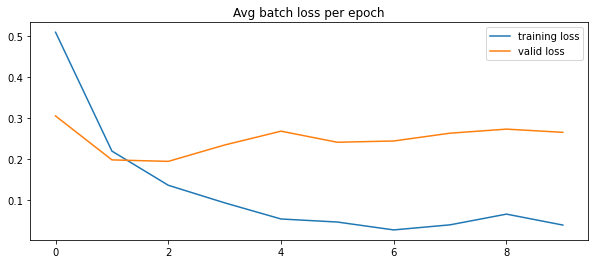

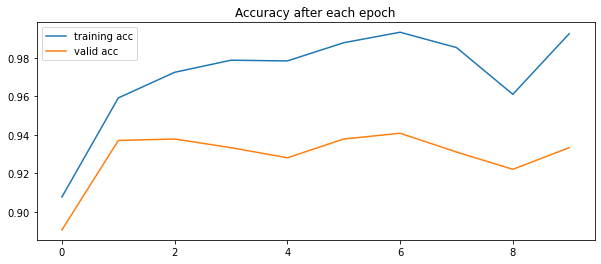

In [61]:
OUTPUT_SIZE = 4 
NUM_EPOCH = 10
EMB_SIZE = 768
BATCH_SIZE = 32
L_RATE = 0.01

model_bert = BertClassifier(EMB_SIZE, OUTPUT_SIZE)
losses, accs = train_batch(model_bert, NUM_EPOCH, BATCH_SIZE, L_RATE, pad_seq=PadSequence(), device=device)
plot_graphs(losses, accs)